In [9]:
from __future__ import absolute_import,division,print_function,unicode_literals
#importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [10]:
data = pd.read_csv('Location\Alipur\cleaned_data.csv')
# Convert the date column to datetime
data['From Date'] = data['From Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['To Date'] = data['To Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['From Date'].min(), data['From Date'].max()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   From Date  1599 non-null   datetime64[ns]
 1   To Date    1599 non-null   datetime64[ns]
 2   PM2.5      1579 non-null   float64       
 3   PM10       1583 non-null   float64       
 4   NO         1582 non-null   float64       
 5   NO2        1582 non-null   float64       
 6   Nox        1582 non-null   float64       
 7   NH3        1567 non-null   float64       
 8   SO2        1566 non-null   float64       
 9   CO         1580 non-null   float64       
 10  Ozone      1538 non-null   float64       
 11  Benzene    1484 non-null   float64       
 12  Toluene    1484 non-null   float64       
 13  RH         1583 non-null   float64       
 14  WD         1583 non-null   float64       
 15  SR         1583 non-null   float64       
 16  BP         1582 non-null   float64       


In [11]:
aq_df = data.set_index('To Date')
aq_df.drop(['From Date'], axis=1, inplace=True)
aq_df.head()

,PM2.5,PM10,NO,NO2,Nox,NH3,SO2,CO,Ozone,Benzene,Toluene,RH,WD,SR,BP,AT,Xylene,TOT-RF
To Date,,,,,,,,,,,,,,,,,,
2018-11-12,251.16,439.83,1.75,83.25,45.69,39.29,23.07,1.57,39.13,6.70,17.96,76.73,240.05,29.55,992.08,19.86,0.31,0.0
2018-11-13,235.81,340.70,4.97,80.06,46.58,35.29,13.32,1.54,44.63,6.57,13.94,77.34,244.45,107.99,990.39,19.82,0.31,0.0
2018-11-14,285.09,428.91,16.67,111.32,72.80,41.51,21.87,1.34,31.22,8.68,43.54,78.66,219.97,77.29,988.21,20.48,0.91,0.0
2018-11-15,144.36,205.45,6.34,96.49,56.09,35.79,12.56,1.00,41.93,5.64,28.66,77.86,214.38,105.27,989.02,21.22,0.54,1.0
2018-11-16,109.24,154.94,6.91,77.06,46.79,30.92,12.69,0.65,28.81,4.17,33.59,79.27,185.82,112.20,992.52,19.82,0.57,0.0


In [12]:
print(aq_df.shape)
print(aq_df.isna().sum())

(1599, 18)
PM2.5       20
PM10        16
NO          17
NO2         17
Nox         17
NH3         32
SO2         33
CO          19
Ozone       61
Benzene    115
Toluene    115
RH          16
WD          16
SR          16
BP          17
AT          17
Xylene     117
TOT-RF       0
dtype: int64


In [13]:
print(aq_df.shape)
print(aq_df.isna().sum())

(1599, 18)
PM2.5       20
PM10        16
NO          17
NO2         17
Nox         17
NH3         32
SO2         33
CO          19
Ozone       61
Benzene    115
Toluene    115
RH          16
WD          16
SR          16
BP          17
AT          17
Xylene     117
TOT-RF       0
dtype: int64


In [14]:
aq_df.drop(['TOT-RF','Xylene','Benzene'], axis=1, inplace=True)

In [15]:
# fill missing values with a value at the same time one day ago
# aq_df.fillna(method='ffill', inplace=True)
# drop the rows with missing values
aq_df.dropna(inplace=True)

In [16]:
# define the train and test data
x_train = aq_df[:'2021-12-31']
y_train = x_train['Ozone']
x_test = aq_df['2022-01-01':]
y_test = x_test['Ozone']
print(y_test)

To Date
2022-01-02 00:00:00    14.24
2022-01-03 00:00:00    11.39
2022-01-04 00:00:00    17.99
2022-01-05 00:00:00    14.20
2022-01-06 00:00:00     7.92
                       ...  
2023-03-25 00:00:00    29.68
2023-03-26 00:00:00    54.00
2023-03-27 00:00:00    48.79
2023-03-28 00:00:00    52.68
2023-03-28 11:31:00    26.29
Name: Ozone, Length: 425, dtype: float64


In [17]:
# calculate length of train and test data
train_len = len(x_train)
test_len = len(x_test)
print(train_len / aq_df.shape[0])
print(test_len / aq_df.shape[0]) 

0.6970776906628653
0.3029223093371347


In [18]:
#Normalizing training data
train_norm = x_train['Ozone']

#converted into array as all the methods available are for arrays and not lists
train_norm_arr = np.asarray(train_norm)
train_norm = np.reshape(train_norm_arr, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)
for i in range(5):
    print(train_norm[i])

[0.37549525]
[0.42997227]
[0.29714739]
[0.403229]
[0.27327655]


In [19]:
#removing null values 
train_norm = train_norm[train_norm!=0]

#Normalizing testing data and repeating the same process as done for training data
test_norm = x_test['Ozone']
test_norm_arr = np.asarray(test_norm)
test_norm = np.reshape(test_norm_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)
for i in range(5):
    print(test_norm[i])

count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1 
print('Number of null values in test_norm = ', count)

[0.11522673]
[0.08801909]
[0.15102625]
[0.11484487]
[0.0548926]
Number of null values in test_norm =  1


In [20]:
#removing null values
test_norm = test_norm[test_norm != 0]

In [21]:
print(train_norm.shape)
print(test_norm.shape)

(977,)
(424,)


Since this is a time series data, we should be predicting the values after looking at a set of values rather than just a single value like we usually do. This takes into account the correlation between the data points and the timestamps. Because the neighbours should be considered for how the values change over time. Let's define a function to do this.

The below function called split_sequence splits the sequence into sets of n values. This n is given as n_steps (step_size). For example, if n=3, we split the sequence in groups of 3. We create 2 empty lists and append the split sequences.

In [22]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

Here the number of features = 1 as we will be predicting a single value. Let's reshape the split sequences into the format of number of rows, number of columns. (shape[0], shape[1]). In the output, we can see that groups of 3 since n_steps = 3 have been obtained.


In [23]:
n_steps = 15
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train)

[[[0.37549525]
  [0.42997227]
  [0.29714739]
  ...
  [0.28308241]
  [0.14996038]
  [0.23821315]]

 [[0.42997227]
  [0.29714739]
  [0.403229  ]
  ...
  [0.14996038]
  [0.23821315]
  [0.20255547]]

 [[0.29714739]
  [0.403229  ]
  [0.27327655]
  ...
  [0.23821315]
  [0.20255547]
  [0.17224643]]

 ...

 [[0.12579239]
  [0.15540808]
  [0.15897385]
  ...
  [0.11737322]
  [0.08161648]
  [0.1026149 ]]

 [[0.15540808]
  [0.15897385]
  [0.10528922]
  ...
  [0.08161648]
  [0.1026149 ]
  [0.05794374]]

 [[0.15897385]
  [0.10528922]
  [0.16174723]
  ...
  [0.1026149 ]
  [0.05794374]
  [0.07706022]]]
[[[0.37549525]
  [0.42997227]
  [0.29714739]
  ...
  [0.28308241]
  [0.14996038]
  [0.23821315]]

 [[0.42997227]
  [0.29714739]
  [0.403229  ]
  ...
  [0.14996038]
  [0.23821315]
  [0.20255547]]

 [[0.29714739]
  [0.403229  ]
  [0.27327655]
  ...
  [0.23821315]
  [0.20255547]
  [0.17224643]]

 ...

 [[0.12579239]
  [0.15540808]
  [0.15897385]
  ...
  [0.11737322]
  [0.08161648]
  [0.1026149 ]]

 [[0.155

In [24]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))


[0.11522673 0.08801909 0.15102625 0.11484487 0.0548926  0.07885442
 0.08267303 0.21804296 0.11312649 0.06071599 0.05966587 0.03866348
 0.07646778 0.04286396 0.06090692] 0.04668257756563246
[0.08801909 0.15102625 0.11484487 0.0548926  0.07885442 0.08267303
 0.21804296 0.11312649 0.06071599 0.05966587 0.03866348 0.07646778
 0.04286396 0.06090692 0.04668258] 0.07312649164677805
[0.15102625 0.11484487 0.0548926  0.07885442 0.08267303 0.21804296
 0.11312649 0.06071599 0.05966587 0.03866348 0.07646778 0.04286396
 0.06090692 0.04668258 0.07312649] 0.07723150357995227
[0.11484487 0.0548926  0.07885442 0.08267303 0.21804296 0.11312649
 0.06071599 0.05966587 0.03866348 0.07646778 0.04286396 0.06090692
 0.04668258 0.07312649 0.0772315 ] 0.201909307875895
[0.0548926  0.07885442 0.08267303 0.21804296 0.11312649 0.06071599
 0.05966587 0.03866348 0.07646778 0.04286396 0.06090692 0.04668258
 0.07312649 0.0772315  0.20190931] 0.082673031026253


In [17]:
# import the fucntion for Support folder from the same directory
from LSTM_Model import build_lstm_model
# n_steps = 15
# n_features = 1
input_shape = (n_steps, n_features)
num_lstm_units = 64
num_hidden_layers = 2
num_units_hidden_layers = 32
activation_function = 'tanh'
dropout_rate = 0.2

model = build_lstm_model(input_shape, num_lstm_units, num_hidden_layers, num_units_hidden_layers, activation_function, dropout_rate)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
#  fit model
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=50, verbose = 1)


Epoch 1/50
31/31 [==============================] - 3s 19ms/step - loss: 0.0656 - mae: 0.1948 - val_loss: 0.0225 - val_mae: 0.1281
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0241 - mae: 0.1207 - val_loss: 0.0131 - val_mae: 0.0902
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0186 - mae: 0.0995 - val_loss: 0.0119 - val_mae: 0.0757
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0168 - mae: 0.0956 - val_loss: 0.0106 - val_mae: 0.0719
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0155 - mae: 0.0903 - val_loss: 0.0109 - val_mae: 0.0708
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0140 - mae: 0.0874 - val_loss: 0.0104 - val_mae: 0.0726
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0145 - mae: 0.0865 - val_loss: 0.0103 - val_mae: 0.0686
Epoch 8/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0151 - mae: 

In [19]:
yhat = model.predict(X_split_test)

13/13 [==============================] - 0s 3ms/step


In [20]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_split_test, yhat)
print('MSE: %.5f' % mse)
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)
r2 = r2_score(y_split_test, yhat)
print('R2: %.5f' % r2)

MSE: 0.00993
RMSE: 0.09965
R2: 0.63289


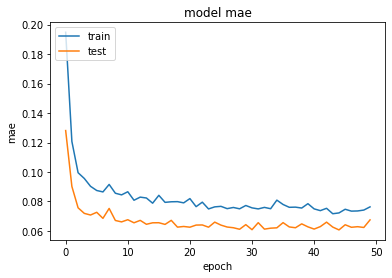

In [21]:
# summarize history for accuracy
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

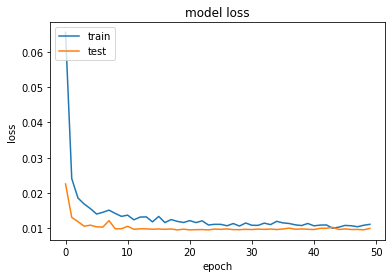

In [22]:
# Above, accuracy increase a lot in the last few epochs. Below, the loss gradually decrease. These are positive signs that our model is doing very good.

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

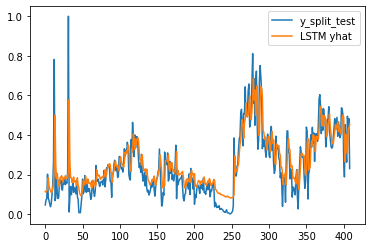

In [23]:
# plot yhat and y_split_test
plt.plot(y_split_test, label='y_split_test')
plt.plot(yhat, label='LSTM yhat')
plt.legend()

# Bidirectional LSTM

In [29]:
from LSTM_Model import build_bidirectional_lstm_model
from keras.optimizers import Adam

n_steps = 10
n_features = 5
input_shape = (n_steps, n_features)
num_lstm_units = 64
num_dense_units = 50
dense_activation_function = 'tanh'
optimizer = Adam(lr=0.001)

B_model = build_bidirectional_lstm_model(input_shape, num_lstm_units, num_dense_units, dense_activation_function, optimizer)

#  fit model
hist = B_model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=50, verbose = 1)


Epoch 1/50


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 3s 24ms/step - loss: 0.0373 - mae: 0.1453 - val_loss: 0.0129 - val_mae: 0.0826
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0150 - mae: 0.0893 - val_loss: 0.0106 - val_mae: 0.0722
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0131 - mae: 0.0816 - val_loss: 0.0107 - val_mae: 0.0741
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0120 - mae: 0.0787 - val_loss: 0.0103 - val_mae: 0.0713
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0113 - mae: 0.0759 - val_loss: 0.0099 - val_mae: 0.0685
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0111 - mae: 0.0758 - val_loss: 0.0096 - val_mae: 0.0652
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0109 - mae: 0.0747 - val_loss: 0.0097 - val_mae: 0.0658
Epoch 8/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0108 - mae: 0.0750 

In [30]:
B_yhat = B_model.predict(X_split_test)
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_split_test, B_yhat)
print('MSE: %.5f' % mse)
rmse = sqrt(mse)
print('RMSE: %.5f' % rmse)
# R2 score
r2 = r2_score(y_split_test, B_yhat)
print('R2: %.5f' % r2)

13/13 [==============================] - 1s 7ms/step
MSE: 0.00965
RMSE: 0.09824
R2: 0.64320


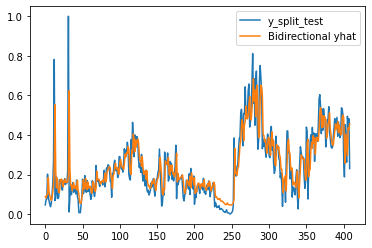

In [31]:
# plot yhat and y_split_test
plt.plot(y_split_test, label='y_split_test')
plt.plot(B_yhat, label='Bidirectional yhat')
plt.legend()

# Multiple Layer Regression (MLR)

In [25]:
# write the function for the MLR model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def build_mlr_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    mse = mean_squared_error(y_test, yhat)
    print('MSE: %.5f' % mse)
    rmse = sqrt(mse)
    print('RMSE: %.5f' % rmse)
    # R2 score
    r2 = r2_score(y_test, yhat)
    print('R2: %.5f' % r2)
    return model, yhat

# build the MLR model
mlr_model, mlr_yhat = build_mlr_model(X train, y_train, X_split_test, y_split_test)

# plot yhat and y_split_test
plt.plot(y_split_test, label='y_split_test')
plt.plot(mlr_yhat, label='MLR yhat')
plt.legend()


ValueError: Found array with dim 3. LinearRegression expected <= 2.